In [1]:
import sys
import warnings
import datacube
from datacube.storage import masking
from datacube.helpers import ga_pq_fuser
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
import pandas as pd
import xarray as xr
from datacube.utils import geometry
from datacube.utils.geometry import CRS
from datacube.helpers import write_geotiff
import os

sys.path.append('../10_Scripts')
import SpatialTools
import gdal
import DEADataHandling
import DEAPlotting

In [86]:
# Connect to datacube database
dc = datacube.Datacube(app='Snow monitoring with Landsat')

output='results/threshold_02/mask/'
years='2002_2003_'

# Set up centre of area to analyse, and a buffer in metres around this centrepoint. Generally,
# aim to keep the buffer size to less than 10,000m to prevent having memory errors

lat, lon, buffer_m = -36.3, 148.35, 8000

# Set range of time to return data from both Landsat and Sentinel 2
time_range = ('2002-01-01', '2003-12-31')

resolution = (-25, 25)

landsat_goodquality_prop = 0.3

ndsi_threshold = 0.2
ndvi_threshold = 0.3
ndwi_threshold = 0.15

x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer_m, x + buffer_m),
         'y': (y - buffer_m, y + buffer_m),    
         'time': time_range,
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
         'resolution': resolution}

In [90]:
print('loading landsat_ds')
snow_mask = dict(                cloud_acca='no_cloud',
                                 #cloud_fmask='no_cloud',
                                 cloud_shadow_acca='no_cloud_shadow',
                                 #cloud_shadow_fmask='no_cloud_shadow',
                                 blue_saturated=False,
                                 green_saturated=False,
                                 red_saturated=False,
                                 nir_saturated=False,
                                 swir1_saturated=False,
                                 swir2_saturated=False,
                                 contiguous=True)

landsat_ds = DEADataHandling.load_clearlandsat(dc=dc, 
                                               product = 'nbar',
                                               query=query,
                                               mask_dict=snow_mask,
                                               sensors=['ls5','ls7','ls8'],
                                               bands_of_interest=['red', 'green', 'blue','nir', 'swir1'],
                                               masked_prop=landsat_goodquality_prop,
                                               mask_pixel_quality=True,
                                               ls7_slc_off=True)

loading landsat_ds
Loading ls5
    Loading 11 filtered ls5 timesteps
Loading ls7
    Loading 47 filtered ls7 timesteps
Loading ls8
    Skipping ls8; no valid data for query
Combining and sorting ls5, ls7 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [112]:
ds_masked = landsat_ds
ndsi_ds = (ds_masked.green - ds_masked.swir1) / (ds_masked.green + ds_masked.swir1)

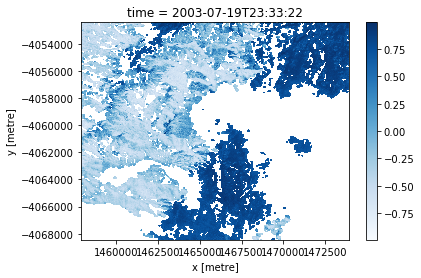

In [93]:
ndsi_ds.isel(time=42).plot(cmap='Blues')

In [113]:
a = ndsi_ds.where(dem_1800.squeeze(dim='time'))
a

<xarray.DataArray (time: 58, y: 641, x: 641)>
array([[[      nan,       nan, ..., -0.570336, -0.533881],
        [      nan,       nan, ..., -0.527042, -0.509398],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       [[      nan,       nan, ...,       nan, -0.518092],
        [      nan,       nan, ..., -0.508801, -0.497863],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       ...,

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       [[      nan,       nan, ..., -0.648918, -0.613684],
        [      nan,       nan, ..., -0.596956, -0.598739],
        ...,
        [      nan,       nan, ...,       nan,       nan]

In [123]:
b = a.mean(dim=('x', 'y'))
# b.time
len(b.values)

58

In [105]:
dem_1800.squeeze(dim='time')

<xarray.DataArray 'dem' (y: 641, x: 641)>
array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
    time     datetime64[ns] 2014-12-15T14:58:44
  * y        (y) float64 -4.052e+06 -4.052e+06 ... -4.068e+06 -4.068e+06
  * x        (x) float64 1.458e+06 1.458e+06 1.458e+06 ... 1.474e+06 1.474e+06

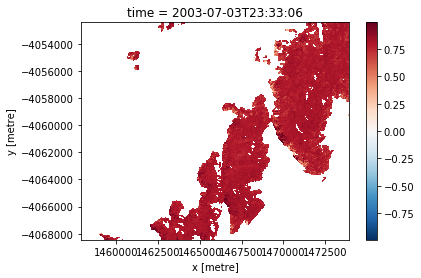

In [101]:
a.isel(time=41).plot()

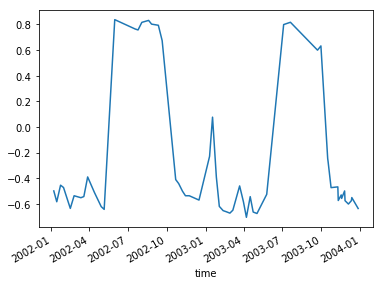

In [104]:
a.mean(dim=('x', 'y')).plot()

In [5]:
print('loading landsat_ds')
landsat_ds = DEADataHandling.load_clearlandsat(dc=dc, 
                                               product = 'nbar',
                                               query=query,

                                               sensors=['ls5','ls7','ls8'],
                                               bands_of_interest=['red', 'green', 'blue','nir', 'swir1'],
                                               masked_prop=landsat_goodquality_prop,
                                               mask_pixel_quality=False,
                                               ls7_slc_off=True)

#landsat_ds = dc.load(product='ls8_nbar_albers', group_by='solar_day', **query)
# Set all nodata pixels to `NaN`:
#landsat_ds = masking.mask_invalid_data(landsat_ds)

# load pq
# ls8: feb2013 - , ls7:apr1999-, ls5: mar1984-jan2013

sensor_pq8 = dc.load(product='ls8_pq_albers', fuse_func=ga_pq_fuser, group_by='solar_day', **query)
sensor_pq7 = dc.load(product='ls7_pq_albers', fuse_func=ga_pq_fuser, group_by='solar_day', **query)
sensor_pq5 = dc.load(product='ls5_pq_albers', fuse_func=ga_pq_fuser, group_by='solar_day', **query)

# good_quality8 = masking.make_mask(sensor_pq8.pixelquality,
#                                  cloud_acca='no_cloud',
#                                  #cloud_fmask='no_cloud',
#                                  cloud_shadow_acca='no_cloud_shadow',
#                                  #cloud_shadow_fmask='no_cloud_shadow',
#                                  blue_saturated=False,
#                                  green_saturated=False,
#                                  red_saturated=False,
#                                  nir_saturated=False,
#                                  swir1_saturated=False,
#                                  swir2_saturated=False,
#                                  contiguous=True)

good_quality7 = masking.make_mask(sensor_pq7.pixelquality,
                                 cloud_acca='no_cloud',
                                 #cloud_fmask='no_cloud',
                                 cloud_shadow_acca='no_cloud_shadow',
                                 #cloud_shadow_fmask='no_cloud_shadow',
                                 blue_saturated=False,
                                 green_saturated=False,
                                 red_saturated=False,
                                 nir_saturated=False,
                                 swir1_saturated=False,
                                 swir2_saturated=False,
                                 contiguous=True)

good_quality5 = masking.make_mask(sensor_pq5.pixelquality,
                                 cloud_acca='no_cloud',
                                 #cloud_fmask='no_cloud',
                                 cloud_shadow_acca='no_cloud_shadow',
                                 #cloud_shadow_fmask='no_cloud_shadow',
                                 blue_saturated=False,
                                 green_saturated=False,
                                 red_saturated=False,
                                 nir_saturated=False,
                                 swir1_saturated=False,
                                 swir2_saturated=False,
                                 contiguous=True)

filtered_sensors=[
#                 good_quality8,
                good_quality7,
               good_quality5
                 ]

combined_ds = xr.concat(filtered_sensors, dim='time')
combined_ds = combined_ds.sortby('time')  

ds_masked = landsat_ds.where(combined_ds)


loading landsat_ds
Loading ls5
    Loading 11 filtered ls5 timesteps
Loading ls7
    Loading 46 filtered ls7 timesteps
Loading ls8
    Skipping ls8; no valid data for query
Combining and sorting ls5, ls7 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [7]:
print('calculating indicies')
ndsi_ds = (ds_masked.green - ds_masked.swir1) / (ds_masked.green + ds_masked.swir1)
ndvi_ds = (ds_masked.nir - ds_masked.red) / (ds_masked.nir + ds_masked.red)
ndwi_ds = (ds_masked.green - ds_masked.nir)/(ds_masked.green + ds_masked.nir)

valid_ds = np.isfinite(ds_masked.swir1)

# snow_ds = ndsi_ds > ndsi_threshold
# noveg_ds = ndvi_ds < ndvi_threshold
# nowater_ds = ndwi_ds < ndwi_threshold
# snow_ds = noveg_ds & snow_ds & nowater_ds

#snow_ds.to_netcdf(output+years+'mask_snow_ds_02.nc')




calculating indicies
exporting netCDF


In [28]:
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer_m, x + buffer_m),
         'y': (y - buffer_m, y + buffer_m),    
#          'time': time_range,
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
         'resolution': resolution}

# Load the DEM data
dem_ds = dc.load(product='srtm_dem1sv1_0', **query)
dem_1800 = dem_ds.dem > 1800

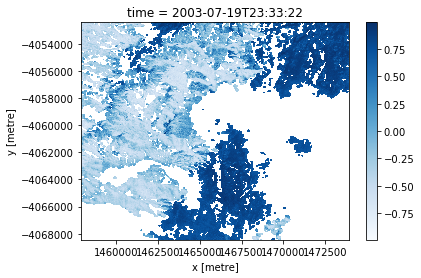

In [77]:
ndsi_ds.isel(time=41).plot(cmap='Blues')

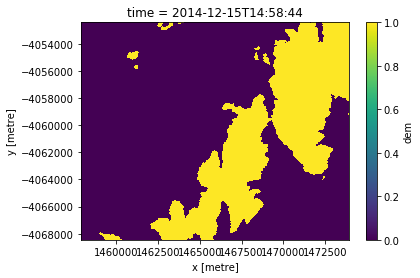

In [68]:
dem_1800.plot()

In [80]:
f = ndsi_ds.isel(time=41).values * dem_1800

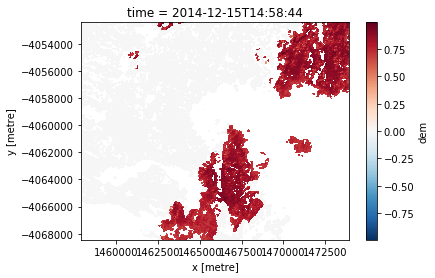

In [84]:
f.plot()

In [82]:
f.sum()/np.count_nonzero(f)

<xarray.DataArray 'dem' ()>
array(0.151487)

In [73]:
f

<xarray.DataArray 'dem' (time: 1, y: 641, x: 641)>
array([[[-0.      , -0.      , ...,  0.824485,  0.812908],
        [-0.      , -0.      , ...,  0.801477,  0.802526],
        ...,
        [-0.      , -0.      , ..., -0.      , -0.      ],
        [ 0.      ,  0.      , ..., -0.      , -0.      ]]])
Coordinates:
  * time     (time) datetime64[ns] 2014-12-15T14:58:44
  * y        (y) float64 -4.052e+06 -4.052e+06 ... -4.068e+06 -4.068e+06
  * x        (x) float64 1.458e+06 1.458e+06 1.458e+06 ... 1.474e+06 1.474e+06

In [42]:
#ds_masked[['red', 'green', 'blue']].isel(time=5).to_array().plot.imshow(robust=True)

In [37]:
g = ndsi_ds.where(dem_1800)

In [38]:
g

<xarray.DataArray (time: 0, y: 641, x: 641)>
array([], shape=(0, 641, 641), dtype=float64)
Coordinates:
  * time     (time) datetime64[ns] 
  * y        (y) float64 -4.052e+06 -4.052e+06 ... -4.068e+06 -4.068e+06
  * x        (x) float64 1.458e+06 1.458e+06 1.458e+06 ... 1.474e+06 1.474e+06

In [31]:
#ndsi_ds.isel(time=15).plot(cmap='Blues')

In [8]:
# a = list(range(len(ndsi_ds.time)))
# ave_ndsi=[]

# for i in a:
#     f = ndsi_ds.isel(time=i).values * dem_1800
#     n = np.count_nonzero(f)
#     if n == 0:
#         n = n+1
#     b = float(f.sum() / n)
#     ave_ndsi.append(b)


# df = pd.DataFrame({'dayofyear':ndsi_ds['time.dayofyear'], 'average_ndsi':ave_ndsi, 'year':ndsi_ds['time.year']})
# df.to_csv(output+years+'phenology.csv')

In [26]:
f = ndsi_ds.isel(time=1).values * dem_1800


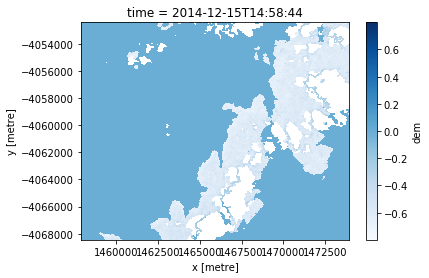

In [27]:
f.plot(cmap="Blues")

In [21]:
f.sum()/np.count_nonzero(f)

<xarray.DataArray 'dem' ()>
array(0.366386)